# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

This project aims to help us in finding an optimal location to open a Japanese Sushi Restaurant in Toronto, Canada. In other words, this project will be delivering a reference in venue for people who are interested in opening a Sushi store in Toronto, Canada.

Toronto is one of the diversified and wealthiest cities in Canada. The multi-cultural city attracts many restaurants with different cuisines. In this project, we will only focus on all areas in Toronto. We will conclude the existing Sushi restaurants compared to all other restaurants, and will use clustering to find similar areas in Toronto regarding restaurants of each borough. The preferred area shall be distant from existing restaurants. We will use data science tools to fetch the raw data, visualize it then generate a few most promising areas based on the above criteria. We will also explain the advantage and traits for the candidates, so that stakeholders can make the final decision base on the analysis.

## Data <a name="data"></a>

Based on the definition of our problem, factors that may impact our decision are number of existing restaurants in the neighborhood and nearby. Restaurant data in every neighborhood will be obtained using Foursquare API. We will extract the coordinates of all restaurants and their scoring, With the information about venues around a given neighborhood, we can create a dataframe where we can see what kind of venue appears around the neighborhoods in that city and their frequency of appearance. These frequencies are weighted. We can then weight the frequency of these venues in our dataframe for each neighborhood.

First we obtain the data of postal codes in Toronto by using BeautifulSoup constructor to find the necessary html table in wikipedia

In [1]:
#Retreive the URL and create a Beautiful soup object
from bs4 import BeautifulSoup
import requests
import pandas as pd
URL = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
source = requests.get(URL).text
soup = BeautifulSoup(source, 'xml')
soup

#create a list and create a dictionary called cell having 3 keys
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned': # Ignore cells with a borough that is Not assigned
        pass
    else:
        cell['Postal Code'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

#Create a dataframe with list
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

df.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


Next we gather the coordinates (latitude and longitude) of each Postal code from the csv file provided

In [2]:
import pandas as pd
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv'
latlon = pd.read_csv(url)
latlon.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [3]:
df.shape

(103, 3)

Merge to get a summary table

In [4]:
df_merge = pd.merge(df,latlon,on='Postal Code')
df_merge

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto Business,Enclave of M4L,43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


In [5]:
print('There are ',len(df_merge['Borough'].unique()),'of Boroughs in Toronto')
print('There are ',len(df_merge['Neighborhood'].unique()),'of Neighborhoods in Toronto')


There are  15 of Boroughs in Toronto
There are  103 of Neighborhoods in Toronto


At the same time, we will download and import the necessary libraries that we will use for the project

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import json, lxml
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
!pip install folium
import folium
from folium import plugins
from folium.plugins import HeatMap
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Explore the neighborhoods in Toronto by the use of geopy library to get the latitude and longitude values of Toronto. Then we can visualize the data we have:

In [7]:
address = 'Toronto'

geolocator = Nominatim(user_agent="toto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [8]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_merge['Latitude'], df_merge['Longitude'], df_merge['Borough'], df_merge['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [9]:
map_toronto.save("toronto.html")

## Foursquare

We then use Foursquare API to get the information on food venues in each neighborhood.

As we know that Japanese foods are diversed and separated between each category, for example a sushi restaurant can be considered totally different from a Sushi restaurant, so we are only interested in venues in the 'Sushi Restaurant' category only. and will not consider other kind of Japanese restaurants.

We will generate asian restaurant venues based on the distance to the neighborhoods. We will take the radius as 2000 from the centre of the neighborhood and limit to 1000 restaurant for each neighborhood.

Finally, we will extract the name, latitude and longitude, postal code and distance of the food venue from the json file we received using the foursquare api and collect it in a dataframe.


In [10]:
#Define Foursquare credentials and version, and specify category of "Japanese restaurant"

CLIENT_ID = 'LAUSAOG2AYHMGJHQVFFRRXOHGH3CJ5VDIB0D0RINJXDZIX2E'
CLIENT_SECRET = 'IGPMOZUNPCMYCCMZJXOEAJ13WHVI0ANPOUZ5OELMKGE51LPP'
VERSION = '20180605'
Category ='4bf58dd8d48988d142941735'
LIMIT = 2000

In [11]:
def getNearbyVenues(postalcodes, boroughs, names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for postalcode, borough, name, lat, lng in zip(postalcodes, boroughs, names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            Category, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            postalcode, 
            borough,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'], 
            v['venue']['location'].get('postalCode', ''),  
            v['venue']['location'].get('distance', ''),  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood Postal Code',
                  'Borough',
                  'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Postal Code',
                  'Venue Distance',
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
# get all venues
all_venues = getNearbyVenues(postalcodes=df_merge['Postal Code'], 
                             boroughs=df_merge['Borough'],
                             names=df_merge['Neighborhood'],
                             latitudes=df_merge['Latitude'],
                             longitudes=df_merge['Longitude']
                            )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills North
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview East
The Danforth

In [13]:
print('Total number of items found:', len(all_venues))

Total number of items found: 3904


In [14]:
#Filter out non- Sushi Restaurant
Sushi_venues = all_venues[all_venues['Venue Category'] == 'Sushi Restaurant']
Sushi_venues.head()

,Neighborhood Postal Code,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Postal Code,Venue Distance,Venue Category
6,M3A,North York,Parkwoods,43.753259,-79.329656,Sushi Ichiban,43.758912,-79.310811,,1640,Sushi Restaurant
12,M3A,North York,Parkwoods,43.753259,-79.329656,Robo Sushi,43.754837,-79.349603,M3B 1Y6,1613,Sushi Restaurant
28,M4A,North York,Victoria Village,43.725882,-79.315572,Bento Sushi,43.722265,-79.337631,,1819,Sushi Restaurant
46,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,Qi sushi,43.662552,-79.364258,,968,Sushi Restaurant
53,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,Tachi,43.650596,-79.383396,M5H 2G4,1878,Sushi Restaurant


In [15]:
all_venues.head()

,Neighborhood Postal Code,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Postal Code,Venue Distance,Venue Category
0,M3A,North York,Parkwoods,43.753259,-79.329656,Dragon Pearl Buffet 龍珠,43.753693,-79.349730,M3B 1Y6,1614,Asian Restaurant
1,M3A,North York,Parkwoods,43.753259,-79.329656,Gonoe Sushi,43.745737,-79.345991,M3B 2W6,1557,Japanese Restaurant
2,M3A,North York,Parkwoods,43.753259,-79.329656,Thai One On,43.754583,-79.351543,M3B 1Y2,1765,Thai Restaurant
3,M3A,North York,Parkwoods,43.753259,-79.329656,China Gourmet,43.755189,-79.348382,,1520,Asian Restaurant
4,M3A,North York,Parkwoods,43.753259,-79.329656,Matsuda Japanese Cuisine & Teppanyaki,43.745494,-79.345821,M3B 2W6,1561,Japanese Restaurant


In [16]:
print('Total number of items under "Sushi restaurants" found:', len(Sushi_venues))

Total number of items under "Sushi restaurants" found: 701


In [17]:
#find out unique restaurant names in case of duplication
no_duplicate = all_venues.drop_duplicates(subset='Venue')
no_duplicate_Sushi = Sushi_venues.drop_duplicates(subset='Venue')
print(len(no_duplicate),',',len(no_duplicate_Sushi))

1130 , 186


We have found 1125 Asian restaurants in Toronto in which there are 184 Sushi restaurants. We also know which food venues exactly are in vicinity of every neighborhood. Now we have the required data for our analysis.

## Methodology <a name="methodology"></a>

In this section, we will do data wrangling of the data we gathered for the purpose of determining the density of food venues in each of the Toronto's neighborhoods, and the type of food venues that are the most common in the neighborhoods.

In data wrangling we verify with the collected data in terms of duplications, un-matched addresses by their name, location, category, postal code and distance of every food venue in the city of Toronto.


In the analysis and modelling section, we will present a heatmap to show the density of neighborhoods in terms of food venues and focus on what implications these can have for stakeholders. In addition, we will provide basic information to the stakeholders by considering the most common types of food venues in these neighborhoods. This will allow stakeholders to choose a starting point at the neighborhood level. And finally, we will create clustering (using k-means clustering) to offer stakeholders different alternatives in terms of neighborhood.

## Analysis <a name="analysis"></a>

Since there are overlap of restaurant between neighborhood, we will first make matches using postal codes, we first make them the same type.

In [18]:
for index in range(len(all_venues.loc[:, 'Venue Postal Code'])):
  all_venues.loc[index, 'Venue Postal Code'] = all_venues.loc[index, 'Venue Postal Code'][0:3]

Afterwards, we compare postal codes and mark which venue is located in the right neighborhood or not. We shall not consider restaurants that do not have postal codes.

In [19]:
all_venues['VPostalcode'] = all_venues['Venue Postal Code'].str[:3]
all_venues['Venue Postal Code'].str.strip()
all_venues['VPostalcode'].str.strip()
all_venues['Neighborhood Postal Code'].str.strip()
all_venues.head()

,Neighborhood Postal Code,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Postal Code,Venue Distance,Venue Category,VPostalcode
0,M3A,North York,Parkwoods,43.753259,-79.329656,Dragon Pearl Buffet 龍珠,43.753693,-79.349730,M3B,1614,Asian Restaurant,M3B
1,M3A,North York,Parkwoods,43.753259,-79.329656,Gonoe Sushi,43.745737,-79.345991,M3B,1557,Japanese Restaurant,M3B
2,M3A,North York,Parkwoods,43.753259,-79.329656,Thai One On,43.754583,-79.351543,M3B,1765,Thai Restaurant,M3B
3,M3A,North York,Parkwoods,43.753259,-79.329656,China Gourmet,43.755189,-79.348382,,1520,Asian Restaurant,
4,M3A,North York,Parkwoods,43.753259,-79.329656,Matsuda Japanese Cuisine & Teppanyaki,43.745494,-79.345821,M3B,1561,Japanese Restaurant,M3B


In [20]:
nan_value = float("NaN")
all_venues['Venue Postal Code'].replace("", nan_value, inplace=True)
all_venues.dropna(axis=0, inplace=True)

print(all_venues.shape)

(2846, 12)


2817 restaurants with postal code remains. Now we can remove the duplicated ones by matching the same postal code and the same restaurant name.

In [21]:
all_venues.head()

,Neighborhood Postal Code,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Postal Code,Venue Distance,Venue Category,VPostalcode
0,M3A,North York,Parkwoods,43.753259,-79.329656,Dragon Pearl Buffet 龍珠,43.753693,-79.349730,M3B,1614,Asian Restaurant,M3B
1,M3A,North York,Parkwoods,43.753259,-79.329656,Gonoe Sushi,43.745737,-79.345991,M3B,1557,Japanese Restaurant,M3B
2,M3A,North York,Parkwoods,43.753259,-79.329656,Thai One On,43.754583,-79.351543,M3B,1765,Thai Restaurant,M3B
4,M3A,North York,Parkwoods,43.753259,-79.329656,Matsuda Japanese Cuisine & Teppanyaki,43.745494,-79.345821,M3B,1561,Japanese Restaurant,M3B
5,M3A,North York,Parkwoods,43.753259,-79.329656,Spicy Chicken House,43.760639,-79.325671,M3A,881,Chinese Restaurant,M3A


In [22]:
def checkPostalCodes(row):
    if row['Neighborhood Postal Code'] == row['Venue Postal Code']:
        val = True
    elif row['Venue Postal Code'] == '':
        val = 'Unknown'
    else:
        val = False
    return val

all_venues['Flag'] = all_venues.apply(checkPostalCodes, axis=1)
all_venues

,Neighborhood Postal Code,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Postal Code,Venue Distance,Venue Category,VPostalcode,Flag
0,M3A,North York,Parkwoods,43.753259,-79.329656,Dragon Pearl Buffet 龍珠,43.753693,-79.349730,M3B,1614,Asian Restaurant,M3B,False
1,M3A,North York,Parkwoods,43.753259,-79.329656,Gonoe Sushi,43.745737,-79.345991,M3B,1557,Japanese Restaurant,M3B,False
2,M3A,North York,Parkwoods,43.753259,-79.329656,Thai One On,43.754583,-79.351543,M3B,1765,Thai Restaurant,M3B,False
4,M3A,North York,Parkwoods,43.753259,-79.329656,Matsuda Japanese Cuisine & Teppanyaki,43.745494,-79.345821,M3B,1561,Japanese Restaurant,M3B,False
5,M3A,North York,Parkwoods,43.753259,-79.329656,Spicy Chicken House,43.760639,-79.325671,M3A,881,Chinese Restaurant,M3A,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Li's Oriental Kitchen,43.637787,-79.539134,M9B,1768,Chinese Restaurant,M9B,False
3896,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Chinese Food Gallery,43.643905,-79.533167,M9A,1942,Chinese Restaurant,M9A,False
3897,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Chodang Soon Tofu,43.644062,-79.533144,M9A,1956,Korean Restaurant,M9A,False
3898,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Bento Sushi,43.620388,-79.524005,M8Z,971,Sushi Restaurant,M8Z,True


In [23]:
all_venues['Flag'].value_counts()

False    2154
True      692
Name: Flag, dtype: int64

In [24]:
True_venues = all_venues[all_venues['Flag']==True]
True_venues.head()

,Neighborhood Postal Code,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Postal Code,Venue Distance,Venue Category,VPostalcode,Flag
5,M3A,North York,Parkwoods,43.753259,-79.329656,Spicy Chicken House,43.760639,-79.325671,M3A,881,Chinese Restaurant,M3A,True
23,M4A,North York,Victoria Village,43.725882,-79.315572,The Bean Sprout,43.742229,-79.313577,M4A,1826,Chinese Restaurant,M4A,True
38,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,Zakkushi ざっ串,43.663618,-79.370670,M5A,1318,Japanese Restaurant,M5A,True
39,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,Sukhothai,43.653701,-79.354447,M5A,502,Thai Restaurant,M5A,True
58,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,China Gourmet,43.664180,-79.368359,M5A,1267,Chinese Restaurant,M5A,True


In [25]:
new_venues = True_venues.drop_duplicates()
new_venues.sort_values(by=['Venue'], ascending=True)
new_venues.head()

,Neighborhood Postal Code,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Postal Code,Venue Distance,Venue Category,VPostalcode,Flag
5,M3A,North York,Parkwoods,43.753259,-79.329656,Spicy Chicken House,43.760639,-79.325671,M3A,881,Chinese Restaurant,M3A,True
23,M4A,North York,Victoria Village,43.725882,-79.315572,The Bean Sprout,43.742229,-79.313577,M4A,1826,Chinese Restaurant,M4A,True
38,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,Zakkushi ざっ串,43.663618,-79.370670,M5A,1318,Japanese Restaurant,M5A,True
39,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,Sukhothai,43.653701,-79.354447,M5A,502,Thai Restaurant,M5A,True
58,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,China Gourmet,43.664180,-79.368359,M5A,1267,Chinese Restaurant,M5A,True


In [26]:
new_venues.shape

(692, 13)

In [27]:
new_venues['Venue Category'].unique()

array(['Chinese Restaurant', 'Japanese Restaurant', 'Thai Restaurant',
       'Sushi Restaurant', 'Coffee Shop', 'Asian Restaurant',
       'Restaurant', 'Korean Restaurant', 'Filipino Restaurant',
       'Dim Sum Restaurant', 'Vietnamese Restaurant', 'Ramen Restaurant',
       'New American Restaurant', 'Breakfast Spot', 'Tea Room',
       'Xinjiang Restaurant', 'Indian Restaurant', 'Hakka Restaurant',
       'Taiwanese Restaurant', 'Szechuan Restaurant', 'Café',
       'Hotpot Restaurant', 'Juice Bar', 'Malay Restaurant',
       'Southern / Soul Food Restaurant', 'Fast Food Restaurant',
       'Tibetan Restaurant', 'Indian Chinese Restaurant', 'Sake Bar',
       'Cantonese Restaurant', 'Noodle House', 'Bakery',
       'Dumpling Restaurant', 'Dessert Shop', 'Fried Chicken Joint',
       'Bar', 'Udon Restaurant', 'Japanese Curry Restaurant',
       'Seafood Restaurant', 'BBQ Joint', 'Diner', 'Cambodian Restaurant',
       'Hong Kong Restaurant', 'Shanghai Restaurant',
       'Indonesia

In [28]:
sushi = new_venues[new_venues['Venue Category']=='Sushi Restaurant']
sushi.shape

(103, 13)

We can now finalize 696 Asian restaurants, with 107 Sushi restaurants in it, for further analysis

Let's create a map showing the heat map / density of food venues and try to extract meaningful information from it. Also let's show the neighborhoods on our map for comparisons.

In [29]:
venues_latlons = []
for lat, lon in zip(new_venues['Venue Latitude'], new_venues['Venue Longitude']):
  latlon = [lat, lon]
  venues_latlons.append(latlon)

print(venues_latlons[1])

[43.742228835254664, -79.31357696452841]


In [30]:
address = 'Toronto'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude



In [31]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)
#folium.TileLayer('cartodbpositron').add_to(map_toronto) #cartodbpositron cartodbdark_matter
for lat, lon, neighborhood, borough in zip(new_venues['Venue Latitude'], new_venues['Venue Longitude'],  new_venues['Neighborhood'], new_venues['Borough']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=1,
        parse_html=False).add_to(map_toronto)
HeatMap(venues_latlons).add_to(map_toronto)

map_toronto

In [32]:
map_toronto.save("newdensity.html")

Looks like a few pockets of high restaurant density apart from city center can be found north-east.
Let's create another heatmap map showing density of Sushi restaurants only.

In [33]:
sushi_venues_latlons = []
sushi_venues = new_venues[new_venues['Venue Category']=='Sushi Restaurant']
for lats, lons in zip(sushi_venues['Venue Latitude'], sushi_venues['Venue Longitude']):
  sushilatlon = [lats, lons]
  sushi_venues_latlons.append(sushilatlon)

print(sushi_venues_latlons[1])

[43.655771, -79.363776]


In [34]:
map_torontosushi = folium.Map(location=[latitude, longitude], zoom_start=11)
folium.TileLayer('cartodbpositron').add_to(map_toronto) #cartodbpositron cartodbdark_matter
for lat, lon, neighborhood, borough in zip(sushi_venues['Venue Latitude'], sushi_venues['Venue Longitude'],  sushi_venues['Neighborhood'], sushi_venues['Borough']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=1,
        parse_html=False).add_to(map_torontosushi)
HeatMap(sushi_venues_latlons).add_to(map_torontosushi)

map_torontosushi

In [35]:
map_torontosushi.save("newdensitysushi.html")

Showing only sushi restaurants, the map looks less hot, and we can see that except the neighborhoods at  Downtown, Willowdale, North York has a good density of Asian restaurants as well as Sushi restaurants. As can be understood from here, this area is one of the major food/dining areas.

Let's check how many venues we have for each neighborhood

In [36]:
new_venues.groupby('Neighborhood').count().sort_values(by=['Venue Category'], ascending=False).head()

,Neighborhood Postal Code,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Postal Code,Venue Distance,Venue Category,VPostalcode,Flag
Neighborhood,,,,,,,,,,,,
Willowdale South,60,60,60,60,60,60,60,60,60,60,60,60
"Milliken, Agincourt North, Steeles East, L'Amoreaux East",47,47,47,47,47,47,47,47,47,47,47,47
Christie,39,39,39,39,39,39,39,39,39,39,39,39
Agincourt,37,37,37,37,37,37,37,37,37,37,37,37
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",26,26,26,26,26,26,26,26,26,26,26,26


Now we will check out the number of Sushi restaurants in each neighborhood

In [61]:
sushi_venue = new_venues[new_venues['Venue Category']=='Sushi Restaurant']
sushi_venue.groupby('Neighborhood').count().sort_values(by=['Venue Category'], ascending=False).head(10)

,Neighborhood Postal Code,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Postal Code,Venue Distance,Venue Category,VPostalcode,Flag
Neighborhood,,,,,,,,,,,,
Willowdale South,7,7,7,7,7,7,7,7,7,7,7,7
"High Park, The Junction South",5,5,5,5,5,5,5,5,5,5,5,5
Davisville,5,5,5,5,5,5,5,5,5,5,5,5
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",5,5,5,5,5,5,5,5,5,5,5,5
Christie,4,4,4,4,4,4,4,4,4,4,4,4
Leaside,4,4,4,4,4,4,4,4,4,4,4,4
"Regent Park, Harbourfront",4,4,4,4,4,4,4,4,4,4,4,4
Rosedale,3,3,3,3,3,3,3,3,3,3,3,3
Davisville North,3,3,3,3,3,3,3,3,3,3,3,3


In [38]:
# one hot encoding
toronto_onehot = pd.get_dummies(new_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = new_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,Asian Restaurant,BBQ Joint,Bakery,Bar,Breakfast Spot,Bubble Tea Shop,Buffet,Café,Cambodian Restaurant,...,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tea Room,Thai Restaurant,Tibetan Restaurant,Udon Restaurant,Vietnamese Restaurant,Wine Bar,Xinjiang Restaurant
5,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
58,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
toronto_onehot.shape

(692, 52)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [40]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Asian Restaurant,BBQ Joint,Bakery,Bar,Breakfast Spot,Bubble Tea Shop,Buffet,Café,Cambodian Restaurant,...,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tea Room,Thai Restaurant,Tibetan Restaurant,Udon Restaurant,Vietnamese Restaurant,Wine Bar,Xinjiang Restaurant
0,Agincourt,0.162162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.054054,0.0,0.0,0.0,0.0,0.0,0.0,0.054054,0.0,0.0
1,"Bathurst Manor, Wilson Heights, Downsview North",0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,Bayview Village,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,"Bedford Park, Lawrence Manor East",0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.500000,0.0,0.0,0.0,0.5,0.0,0.0,0.000000,0.0,0.0
4,Berczy Park,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [41]:
toronto_grouped.shape

(87, 52)

First, let's write a function to sort the venues in descending order.

In [42]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [43]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Chinese Restaurant,Asian Restaurant,Cantonese Restaurant,Vietnamese Restaurant,Sushi Restaurant,Hong Kong Restaurant,Noodle House,Filipino Restaurant,Shanghai Restaurant,Diner
1,"Bathurst Manor, Wilson Heights, Downsview North",Asian Restaurant,Filipino Restaurant,Sushi Restaurant,Chinese Restaurant,Comfort Food Restaurant,Hong Kong Restaurant,Hakka Restaurant,Grocery Store,Fried Chicken Joint,Fast Food Restaurant
2,Bayview Village,Japanese Restaurant,Chinese Restaurant,Xinjiang Restaurant,Dessert Shop,Hong Kong Restaurant,Hakka Restaurant,Grocery Store,Fried Chicken Joint,Filipino Restaurant,Fast Food Restaurant
3,"Bedford Park, Lawrence Manor East",Thai Restaurant,Sushi Restaurant,Xinjiang Restaurant,Coffee Shop,Hakka Restaurant,Grocery Store,Fried Chicken Joint,Filipino Restaurant,Fast Food Restaurant,Dumpling Restaurant
4,Berczy Park,Sushi Restaurant,Chinese Restaurant,Xinjiang Restaurant,Comfort Food Restaurant,Hong Kong Restaurant,Hakka Restaurant,Grocery Store,Fried Chicken Joint,Filipino Restaurant,Fast Food Restaurant
...,...,...,...,...,...,...,...,...,...,...,...
82,Willowdale South,Korean Restaurant,Japanese Restaurant,Sushi Restaurant,Ramen Restaurant,Asian Restaurant,Chinese Restaurant,Noodle House,Fried Chicken Joint,Bar,Dessert Shop
83,Willowdale West,Asian Restaurant,Chinese Restaurant,Comfort Food Restaurant,Hong Kong Restaurant,Hakka Restaurant,Grocery Store,Fried Chicken Joint,Filipino Restaurant,Fast Food Restaurant,Dumpling Restaurant
84,"Willowdale, Newtonbrook",Korean Restaurant,Sushi Restaurant,Restaurant,Thai Restaurant,Asian Restaurant,Japanese Restaurant,Chinese Restaurant,Cantonese Restaurant,Sake Bar,Buffet
85,Woodbine Heights,Thai Restaurant,Asian Restaurant,Sushi Restaurant,Coffee Shop,Hakka Restaurant,Grocery Store,Fried Chicken Joint,Filipino Restaurant,Fast Food Restaurant,Dumpling Restaurant


In [44]:
index = 'Willowdale South'
temp = toronto_grouped.set_index('Neighborhood')
temp = temp[temp.index == index]
temp = temp.loc[:, (temp != 0.0).any(axis=0)]
temp.head()

,Asian Restaurant,Bar,Chinese Restaurant,Dessert Shop,Dumpling Restaurant,Fried Chicken Joint,Japanese Curry Restaurant,Japanese Restaurant,Korean Restaurant,Noodle House,Ramen Restaurant,Sushi Restaurant,Thai Restaurant,Udon Restaurant
Neighborhood,,,,,,,,,,,,,,
Willowdale South,0.083333,0.016667,0.083333,0.016667,0.016667,0.05,0.016667,0.15,0.266667,0.05,0.1,0.116667,0.016667,0.016667


Text(0, 0.5, 'Venue Category')

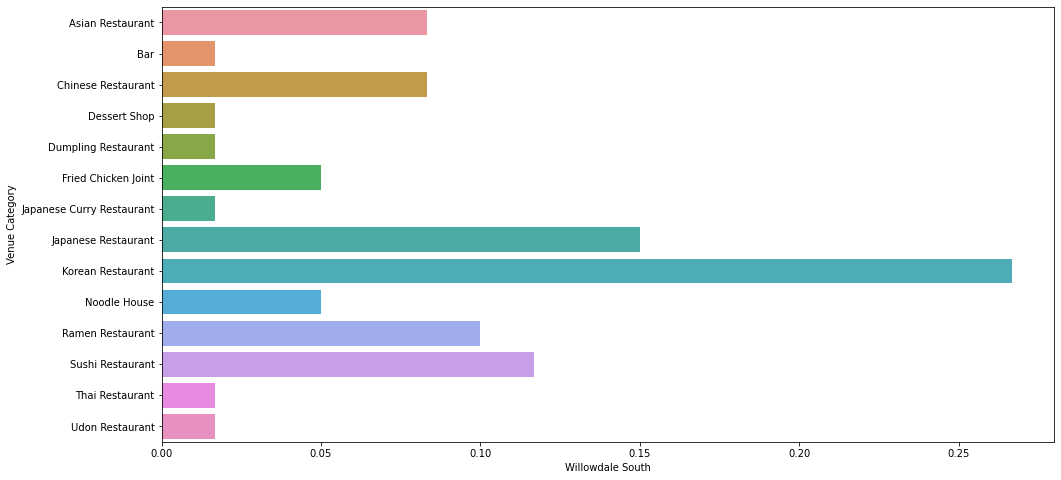

In [45]:
# Set the width and height of the figure
plt.figure(figsize=(16,8))

# Add title
plt.title

("Frequency of Occurrence of Each Venue Category")

# Bar chart showing Frequency of Occurrence of Each Venue Category
sns.barplot(x=temp.iloc[0], y=temp.columns)

# Add label for vertical axis
plt.ylabel("Venue Category")

The Willowdale South neighborhood is the area with the most venues. As seen in the graph, the third common types of food venues in this region are Sushi Restaurants. It is far from the Downtown and is capable for a large number of Asian restaurant business.



# Cluster Neighborhoods

Now let's cluster neighborhoods together to see similar neighborhoods. This will enable us to offer stakeholders different neighborhoods as an alternative.

For this, let's first prepare our dataframe.

In [46]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
toronto_grouped_clustering.head()

,Asian Restaurant,BBQ Joint,Bakery,Bar,Breakfast Spot,Bubble Tea Shop,Buffet,Café,Cambodian Restaurant,Cantonese Restaurant,...,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tea Room,Thai Restaurant,Tibetan Restaurant,Udon Restaurant,Vietnamese Restaurant,Wine Bar,Xinjiang Restaurant
0,0.162162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081081,...,0.054054,0.0,0.0,0.0,0.0,0.0,0.0,0.054054,0.0,0.0
1,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.500000,0.0,0.0,0.0,0.5,0.0,0.0,0.000000,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [47]:
# Considering number of clusters as 9.
k = 9
X = toronto_grouped_clustering

# run k-means clustering
kmeans = KMeans(n_clusters=k, random_state=0, n_init=100)
kmeans.fit(X)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:100]

array([7, 7, 1, 2, 2, 2, 1, 1, 5, 5, 1, 6, 1, 7, 7, 3, 2, 1, 4, 1, 1, 5,
       5, 5, 5, 5, 4, 1, 0, 6, 1, 2, 5, 7, 0, 2, 7, 2, 1, 3, 7, 4, 2, 2,
       2, 5, 7, 7, 2, 2, 2, 0, 1, 7, 2, 3, 2, 4, 2, 2, 1, 2, 1, 0, 8, 0,
       1, 7, 5, 2, 1, 1, 5, 2, 2, 4, 1, 3, 5, 3, 5, 7, 1, 4, 6, 2, 4],
      dtype=int32)

remove neighborhood not in the list

In [48]:
neigh = []
index_list = df_merge['Neighborhood'].tolist()
for ind in index_list:
    b = toronto_grouped[toronto_grouped['Neighborhood'] == ind ]
    if b.empty:
        neigh.append(ind)

print(neigh)

['Ontario Provincial Government', 'Islington Avenue', 'Parkview Hill, Woodbine Gardens', 'Woburn', 'Toronto Dominion Centre, Design Exchange', 'York Mills, Silver Hills', 'Downsview West', 'North Park, Maple Leaf Park, Upwood Park', 'Humber Summit', 'Cliffside, Cliffcrest, Scarborough Village West', 'Humberlea, Emery', 'Enclave of L4W', 'Enclave of M5E', 'Alderwood, Long Branch', 'Upper Rouge', 'Enclave of M4L']


In [49]:
merged_data = df_merge.drop('Postal Code', 1)
for n in neigh:
    indexname = merged_data[merged_data['Neighborhood'] == n].index
    merged_data.drop(indexname,inplace=True)
merged_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,North York,Parkwoods,43.753259,-79.329656
1,North York,Victoria Village,43.725882,-79.315572
2,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
6,Scarborough,"Malvern, Rouge",43.806686,-79.194353


Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [50]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_merged = merged_data
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')


In [51]:
toronto_merged.dropna(axis=0,inplace=True)

In [59]:
toronto_merged.head(10)

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,Parkwoods,43.753259,-79.329656,3,Chinese Restaurant,Xinjiang Restaurant,Comfort Food Restaurant,Hong Kong Restaurant,Hakka Restaurant,Grocery Store,Fried Chicken Joint,Filipino Restaurant,Fast Food Restaurant,Dumpling Restaurant
1,North York,Victoria Village,43.725882,-79.315572,3,Chinese Restaurant,Xinjiang Restaurant,Comfort Food Restaurant,Hong Kong Restaurant,Hakka Restaurant,Grocery Store,Fried Chicken Joint,Filipino Restaurant,Fast Food Restaurant,Dumpling Restaurant
2,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2,Sushi Restaurant,Thai Restaurant,Japanese Restaurant,Chinese Restaurant,Coffee Shop,Comfort Food Restaurant,Hakka Restaurant,Grocery Store,Fried Chicken Joint,Filipino Restaurant
3,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,2,Asian Restaurant,Sushi Restaurant,Restaurant,Japanese Restaurant,Korean Restaurant,Chinese Restaurant,Grocery Store,Fried Chicken Joint,Filipino Restaurant,Fast Food Restaurant
6,Scarborough,"Malvern, Rouge",43.806686,-79.194353,7,Filipino Restaurant,Chinese Restaurant,Xinjiang Restaurant,Comfort Food Restaurant,Hong Kong Restaurant,Hakka Restaurant,Grocery Store,Fried Chicken Joint,Fast Food Restaurant,Dumpling Restaurant
7,North York,Don Mills North,43.745906,-79.352188,1,Japanese Restaurant,Sushi Restaurant,Asian Restaurant,Thai Restaurant,Filipino Restaurant,Dim Sum Restaurant,Comfort Food Restaurant,Hakka Restaurant,Grocery Store,Fried Chicken Joint
9,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,1,Japanese Restaurant,Thai Restaurant,Sushi Restaurant,Asian Restaurant,Ramen Restaurant,Chinese Restaurant,Vietnamese Restaurant,Bar,Breakfast Spot,Grocery Store
10,North York,Glencairn,43.709577,-79.445073,2,Sushi Restaurant,Xinjiang Restaurant,Comfort Food Restaurant,Hong Kong Restaurant,Hakka Restaurant,Grocery Store,Fried Chicken Joint,Filipino Restaurant,Fast Food Restaurant,Dumpling Restaurant
11,Etobicoke,"West Deane Park, Princess Gardens, Martin Grov...",43.650943,-79.554724,5,Chinese Restaurant,Vietnamese Restaurant,Sushi Restaurant,Coffee Shop,Hakka Restaurant,Grocery Store,Fried Chicken Joint,Filipino Restaurant,Fast Food Restaurant,Dumpling Restaurant
12,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,1,Japanese Restaurant,Chinese Restaurant,Xinjiang Restaurant,Dessert Shop,Hong Kong Restaurant,Hakka Restaurant,Grocery Store,Fried Chicken Joint,Filipino Restaurant,Fast Food Restaurant


Let's find out which cluster the neighborhood Willowdale South belongs to

In [68]:
willowdale = toronto_merged[toronto_merged['Neighborhood']== 'Willowdale South']
willowdale

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
59,North York,Willowdale South,43.77012,-79.408493,1,Korean Restaurant,Japanese Restaurant,Sushi Restaurant,Ramen Restaurant,Asian Restaurant,Chinese Restaurant,Noodle House,Fried Chicken Joint,Bar,Dessert Shop


In [69]:
df = toronto_merged[toronto_merged['Cluster Labels']== 1]
df.head(20)

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,North York,Don Mills North,43.745906,-79.352188,1,Japanese Restaurant,Sushi Restaurant,Asian Restaurant,Thai Restaurant,Filipino Restaurant,Dim Sum Restaurant,Comfort Food Restaurant,Hakka Restaurant,Grocery Store,Fried Chicken Joint
9,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,1,Japanese Restaurant,Thai Restaurant,Sushi Restaurant,Asian Restaurant,Ramen Restaurant,Chinese Restaurant,Vietnamese Restaurant,Bar,Breakfast Spot,Grocery Store
12,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,1,Japanese Restaurant,Chinese Restaurant,Xinjiang Restaurant,Dessert Shop,Hong Kong Restaurant,Hakka Restaurant,Grocery Store,Fried Chicken Joint,Filipino Restaurant,Fast Food Restaurant
13,North York,Don Mills South,43.725900,-79.340923,1,Japanese Restaurant,New American Restaurant,Chinese Restaurant,Coffee Shop,Xinjiang Restaurant,Dessert Shop,Hakka Restaurant,Grocery Store,Fried Chicken Joint,Filipino Restaurant
19,East Toronto,The Beaches,43.676357,-79.293031,1,Thai Restaurant,Breakfast Spot,Japanese Restaurant,Ramen Restaurant,Xinjiang Restaurant,Dessert Shop,Hakka Restaurant,Grocery Store,Fried Chicken Joint,Filipino Restaurant
24,Downtown Toronto,Central Bay Street,43.657952,-79.387383,1,Japanese Restaurant,Chinese Restaurant,Tea Room,Sushi Restaurant,Korean Restaurant,Restaurant,Xinjiang Restaurant,Comfort Food Restaurant,Grocery Store,Fried Chicken Joint
33,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,1,Japanese Restaurant,Chinese Restaurant,Asian Restaurant,Restaurant,Juice Bar,Hotpot Restaurant,Hakka Restaurant,Grocery Store,Fried Chicken Joint,Filipino Restaurant
34,North York,"Northwood Park, York University",43.767980,-79.487262,1,Restaurant,Sushi Restaurant,Chinese Restaurant,Asian Restaurant,Japanese Restaurant,Hakka Restaurant,Grocery Store,Fried Chicken Joint,Filipino Restaurant,Fast Food Restaurant
39,North York,Bayview Village,43.786947,-79.385975,1,Japanese Restaurant,Chinese Restaurant,Xinjiang Restaurant,Dessert Shop,Hong Kong Restaurant,Hakka Restaurant,Grocery Store,Fried Chicken Joint,Filipino Restaurant,Fast Food Restaurant
43,West Toronto,"Brockton, Parkdale Village, Exhibition Place",43.636847,-79.428191,1,Japanese Restaurant,Ramen Restaurant,Vietnamese Restaurant,Thai Restaurant,Sushi Restaurant,Restaurant,Xinjiang Restaurant,Fried Chicken Joint,Filipino Restaurant,Fast Food Restaurant


In [54]:
tm=toronto_merged

Finally, let's visualize the resulting clusters

In [55]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tm['Latitude'], tm['Longitude'], tm['Neighborhood'], tm['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow [cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [56]:
map_clusters.save("newclusters.html")

# Results and Discussion <a name="results"></a>

Our analysis shows that the most popular area in the city of Toronto in terms of Asian food venues is the neighborhood Willowdale South in the North York borough. rom this analysis can we understand that this area has great capability for Asian food venues. However, there are many things to consider when choosing a place for the food venue. For example it may be a valuable place which may not be an optimal  choice for some food venues.

After directing our attention to this more narrow area of interest, we focus only on the competition and restaurant density. In order to evaluate this factor, we presented the neighborhood-based venues we collected and how often they were in which neighborhood as a result of our analysis. For example, although the area consisting of the neighborhood seems like an attractive location, it may not be a good idea for venues. If we are looking for a venue in similar style, we can also consider the neighborhood with the same cluster number, (i.e. 1), such as Don Mills North, The Beaches, Bayview Village etc, at the nearby areas.

Finally, the fact that this study is not inclusive may reveal some drawbacks. One of them is that the information we provide is far from offering pinpoint options for stakeholders. The reason for this is that our analyzes are far from the real field. Therefore, it should not be forgotten that the information we provide will only help stakeholders to choose a starting point in finding a new location for their business.


# Conclusion <a name="conclusion"></a>

The aim of this project is to provide suggestions in venues to assist stakeholders who are considering opening a Sushi restaurant venue in the city of Toronto. There are many factors that affect the location of a food venue. In this study, analyzes were made considering only the competition and density.

By calculating Asian restaurant density distribution from Foursquare data we have first identified general neighborhoods. As a result of the analysis made afterwards, the density of asian food venues in the city was revealed. Thus, the competition factor at the general level was examined. Then, going a little more specific, the frequency of food venues in the neighborhoods was revealed as a result of analysis. Clustering of those locations was then performed in order to create major zones of interest; those zone centers were created to be used as starting points for final exploration by stakeholders.

Finally, it should be noted that the stakeholders should pay attention to all factors when choosing the location for the food venue. We can list these factors as follows: demography, labor costs and minimum wage, access, proximity to suppliers, competition, visibility, future growth, health regulations and zoning, security / crime rates. When the stakeholders consider all these factors, they will be able to choose the best location for their food venues.



In [57]:
!pip install -U notebook-as-pdf


Requirement already up-to-date: notebook-as-pdf in ./opt/anaconda3/lib/python3.8/site-packages (0.5.0)


In [58]:
conda install -c conda-forge pyppeteer

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.
